In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import warnings

warnings.filterwarnings("ignore")
from datetime import datetime
%matplotlib inline


DatetimeIndex(['2022-05-01', '2022-05-02', '2022-05-03', '2022-05-04',
               '2022-05-05', '2022-05-06', '2022-05-07', '2022-05-08',
               '2022-05-09', '2022-05-10',
               ...
               '2022-10-21', '2022-10-22', '2022-10-23', '2022-10-24',
               '2022-10-25', '2022-10-26', '2022-10-27', '2022-10-28',
               '2022-10-29', '2022-10-30'],
              dtype='datetime64[ns]', name='DATE', length=183, freq=None)

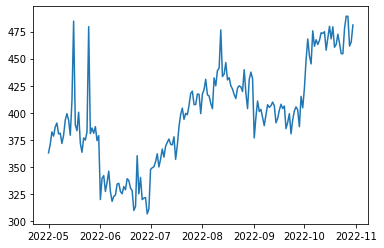

In [3]:
dst=pd.read_excel(r"C:\Users\hp\Downloads\Total Data (Overall).xlsx")
plt.plot(dst['DATE'],dst['Total'])
dst['DATE']=pd.to_datetime(dst['DATE'], infer_datetime_format= True)
 
dst= dst.set_index(['DATE'])
dst.index



In [4]:
from statsmodels.tsa.stattools import adfuller
print('results of dickey-fuller test:')
dftest= adfuller(dst['Total'], autolag='AIC')

dfoutput=pd.Series(dftest[0:4], index=['Test statistic','p-value','#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical value (%s)' %key]= value
print(dfoutput)

results of dickey-fuller test:
Test statistic                  -1.156842
p-value                          0.691880
#Lags Used                       2.000000
Number of Observations Used    180.000000
Critical value (1%)             -3.467211
Critical value (5%)             -2.877735
Critical value (10%)            -2.575403
dtype: float64


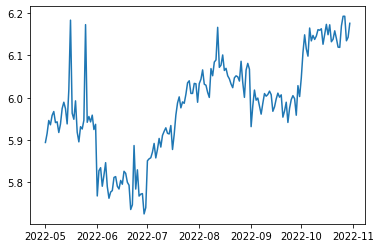

In [5]:
dst_logScale= np.log(dst)
plt.plot(dst_logScale)




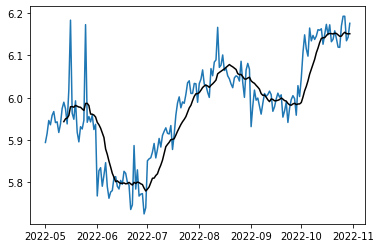

In [13]:
movingaverage= dst_logScale.rolling(window=12).mean()
movingstd= dst_logScale.rolling(window=12).std()
plt.plot(dst_logScale)
plt.plot(movingaverage, color='black')
    

    
    
    


    

In [14]:
newdataset= dst_logScale-movingaverage #this is scale-movingavg
newdataset

newdataset.dropna(inplace=True)

newdataset


,Total
DATE,
2022-05-12,0.045954
2022-05-13,0.024054
2022-05-14,-0.013845
2022-05-15,0.061088
2022-05-16,0.204668
...,...
2022-10-26,0.041364
2022-10-27,0.037864
2022-10-28,-0.016907


In [15]:
from statsmodels.tsa.stattools import adfuller
print('results of dickey-fuller test:')
dftest= adfuller(newdataset, autolag='AIC')

dfoutput=pd.Series(dftest[0:4], index=['Test statistic','p-value','#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical value (%s)' %key]= value
print(dfoutput)

results of dickey-fuller test:
Test statistic                  -4.029425
p-value                          0.001264
#Lags Used                       2.000000
Number of Observations Used    169.000000
Critical value (1%)             -3.469648
Critical value (5%)             -2.878799
Critical value (10%)            -2.575971
dtype: float64


In [16]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    ma= dst_logScale.rolling(window=12).mean()
    mstd= dst_logScale.rolling(window=12).std()
    orig=plt.plot(timeseries, color='blue', label='original')
    mean= plt.plot(ma, color='red', label='Rolling Mean')
    std= plt.plot(mstd, color='black', label ='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    
    #dickey-fuller test
    print('Results of dickey fuller test:')
    dftest= adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test statistic','p-value','#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical value (%s)' %key]= value
    print(dfoutput)

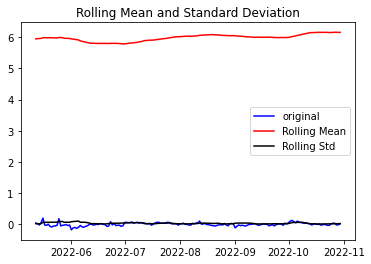

Results of dickey fuller test:
Test statistic                  -4.029425
p-value                          0.001264
#Lags Used                       2.000000
Number of Observations Used    169.000000
Critical value (1%)             -3.469648
Critical value (5%)             -2.878799
Critical value (10%)            -2.575971
dtype: float64


In [17]:
test_stationarity(newdataset)

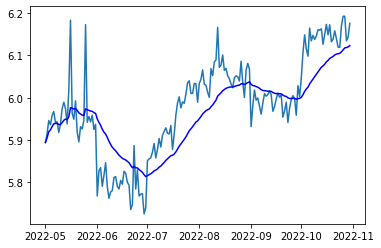

In [18]:
exponentialdecayweightedaverage= dst_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(dst_logScale)
plt.plot(exponentialdecayweightedaverage, color='blue')

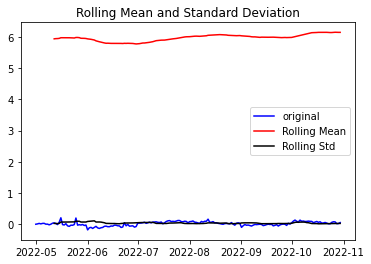

Results of dickey fuller test:
Test statistic                  -2.723015
p-value                          0.070140
#Lags Used                       2.000000
Number of Observations Used    180.000000
Critical value (1%)             -3.467211
Critical value (5%)             -2.877735
Critical value (10%)            -2.575403
dtype: float64


In [19]:
dstlsMEDA= dst_logScale - exponentialdecayweightedaverage
test_stationarity(dstlsMEDA)

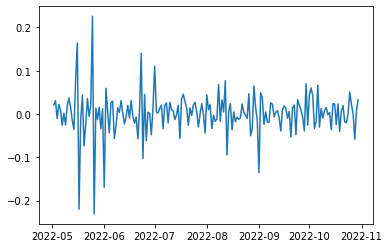

In [20]:
dstLogshift= dst_logScale - dst_logScale.shift()
plt.plot(dstLogshift)

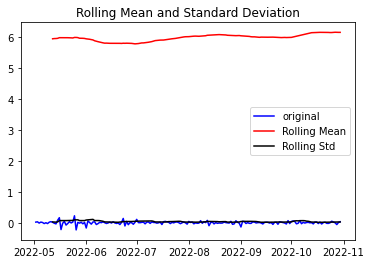

Results of dickey fuller test:
Test statistic                -1.461549e+01
p-value                        3.960412e-27
#Lags Used                     1.000000e+00
Number of Observations Used    1.800000e+02
Critical value (1%)           -3.467211e+00
Critical value (5%)           -2.877735e+00
Critical value (10%)          -2.575403e+00
dtype: float64


In [21]:
dstLogshift.dropna(inplace= True)
test_stationarity(dstLogshift)

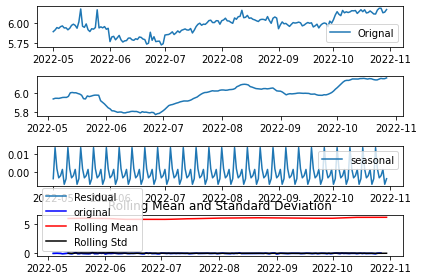

Results of dickey fuller test:
Test statistic                -7.331667e+00
p-value                        1.123655e-10
#Lags Used                     1.000000e+01
Number of Observations Used    1.660000e+02
Critical value (1%)           -3.470370e+00
Critical value (5%)           -2.879114e+00
Critical value (10%)          -2.576139e+00
dtype: float64


In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dst_logScale)

trend= decomposition.trend
seasonal= decomposition.seasonal
residual= decomposition.resid

plt.subplot(411)
plt.plot(dst_logScale, label='Orignal')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label= 'Trend')
plt.plot(loc='best')
plt.subplot(413)
plt.plot(seasonal , label='seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc='best')
plt.tight_layout()



decomposedLogdata= residual
decomposedLogdata.dropna(inplace=True)
test_stationarity(decomposedLogdata)


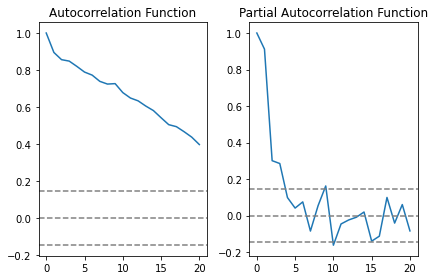

In [70]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(dst, nlags=20)
lag_pacf= pacf(dst, nlags=20, method='ols')

#plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dst)),linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dst)),linestyle='--', color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dst)),linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dst)),linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


Plotting AR model


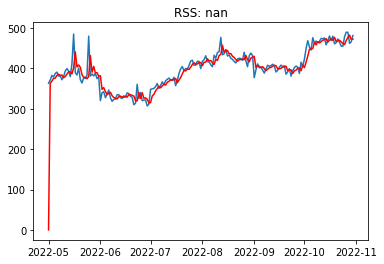

In [68]:
import statsmodels.api as smapi

model = smapi.tsa.arima.ARIMA(dst, order=(2,1,2))

results_AR = model.fit()
plt.plot(dst)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum(results_AR.fittedvalues-dstLogshift['Total'])**2)

print('Plotting AR model')

Plotting MA model


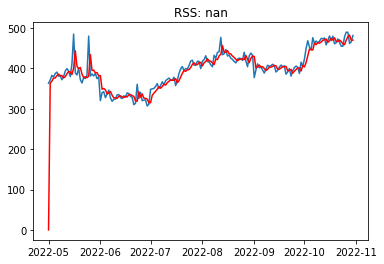

In [67]:


model = smapi.tsa.arima.ARIMA(dst, order=(0,1,2))

results_MA = model.fit()
plt.plot(dst)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum(results_MA.fittedvalues-dstLogshift['Total'])**2)

print('Plotting MA model')


Plotting ARIMA model


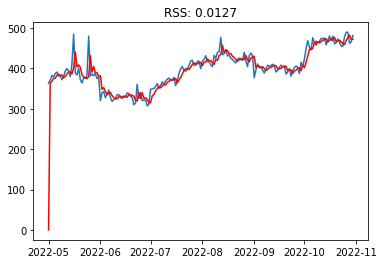

In [66]:
model= smapi.tsa.arima.ARIMA(dst, order=(2,1,2))
results_ARIMA= model.fit()
plt.plot(dst)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum(results_MA.fittedvalues-dstLogshift['Total'])**2)
print('Plotting ARIMA model')

In [54]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

DATE
2022-05-01      0.000000
2022-05-02    362.949361
2022-05-03    368.170892
2022-05-04    375.115943
2022-05-05    375.448681
                 ...    
2022-10-26    468.933326
2022-10-27    476.274020
2022-10-28    482.076894
2022-10-29    471.273129
2022-10-30    472.192282
Length: 183, dtype: float64


In [55]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)


DATE
2022-05-01        0.000000
2022-05-02      362.949361
2022-05-03      731.120253
2022-05-04     1106.236195
2022-05-05     1481.684877
                  ...     
2022-10-26    70440.547934
2022-10-27    70916.821954
2022-10-28    71398.898847
2022-10-29    71870.171977
2022-10-30    72342.364259
Length: 183, dtype: float64


In [56]:
predictions_ARIMA_log=pd.Series(dst_logScale['Total'], index=dst_logScale.index)
predictions_ARIMA_log= predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log

DATE
2022-05-01        5.894392
2022-05-02      368.864927
2022-05-03      737.066608
2022-05-04     1112.172381
2022-05-05     1487.643192
                  ...     
2022-10-26    70446.740610
2022-10-27    70923.014659
2022-10-28    71405.033545
2022-10-29    71876.315006
2022-10-30    72348.540281
Length: 183, dtype: float64

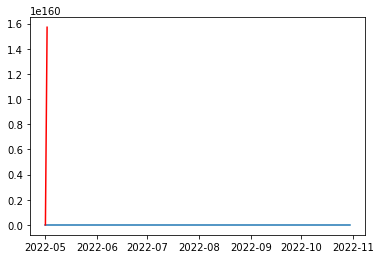

In [57]:
predictions_ARIMA= np.exp(predictions_ARIMA_log)
plt.plot(dst)
plt.plot(predictions_ARIMA, color='red')

In [58]:
dst_logScale

,Total
DATE,
2022-05-01,5.894392
2022-05-02,5.915566
2022-05-03,5.946355
2022-05-04,5.936186
2022-05-05,5.958315
...,...
2022-10-26,6.192676
2022-10-27,6.192705
2022-10-28,6.134698


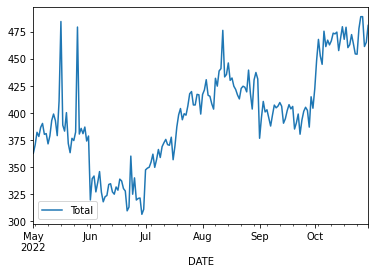

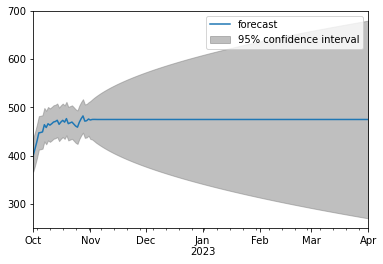

In [61]:
from statsmodels.graphics.tsaplots import plot_predict
fig, ax = plt.subplots()
dst.loc[:].plot(ax=ax)
plot_predict(results_ARIMA, '2022-10-01', '2023-04-01')

plt.show()

